### plot the outflows from VLA1

#### 5/11/23  jpw

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
from astropy.wcs import WCS
from astropy.io import fits
from radio_beam import Beam
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.patches import Ellipse
from astropy.visualization import (MinMaxInterval, SqrtStretch, SinhStretch, AsinhStretch, LogStretch, ImageNormalize)
from matplotlib.patches import Ellipse
%matplotlib inline

#### read in continuum

In [2]:
path = 'data/'
filename = "OphIRS43_SBLB_continuum_robust_-1.0.pbcor.tt0.fits"

hdu = fits.open(path+filename)
im = hdu[0].data.squeeze()
hd = hdu[0].header
hdu.close()

# conversion to brightness temperature
omega = np.pi * hd['BMAJ'] * hd['BMIN'] / (4 * np.log(2))   # degrees**2
omega *= (np.pi/180)**2                                     # steradians
wl = 0.128                                                  # wavelength in cm (nu = 234 GHz)
cont_Tb  = wl**2 * 1e-23 * im / (2 * 1.36e-16 * omega)      # cgs
cont_hd = hd

#### read in the line data

In [3]:
filename1 = "12co.fits"
hdu = fits.open(path+filename1)
im1 = hdu[0].data.squeeze()
hd1 = hdu[0].header
hdu.close()

filename2 = "so.fits"
hdu = fits.open(path+filename2)
im2 = hdu[0].data.squeeze()
hd2 = hdu[0].header
hdu.close()

In [4]:
hd = hd1
nu0 = hd['RESTFRQ']
nu = hd['CRVAL3'] + (1+np.arange(hd['NAXIS3'])-hd['CRPIX3'])*hd['CDELT3']
v = (1 - nu/nu0) * c.c.si.value/1e3

In [5]:
vla1 = SkyCoord('16h27m26.906s', '-24d40m50.82s', frame='icrs')
vla2 = SkyCoord('16h27m26.911s', '-24d40m51.40s', frame='icrs')
dra, ddec = vla1.spherical_offsets_to(vla2)
x_vla2 = dra.to(u.arcsec).value
y_vla2 = ddec.to(u.arcsec).value

td = SkyCoord('16h27m26.602s', '-24d40m45.70s', frame='icrs')
dra, ddec = vla1.spherical_offsets_to(td)
x_td = dra.to(u.arcsec).value
y_td = ddec.to(u.arcsec).value

In [6]:
def crop_image(im, hd, extent, center=vla1):
    ra  = hd['CRVAL1'] + (1+np.arange(hd['NAXIS1'])-hd['CRPIX1'])*hd['CDELT1']    # degrees
    dec = hd['CRVAL2'] + (1+np.arange(hd['NAXIS2'])-hd['CRPIX2'])*hd['CDELT2']
    dra = (ra - center.ra.value) * 3600
    ddec = (dec - center.dec.value) * 3600
    
    imin = np.argmin(np.abs(dra-extent[0]))
    imax = np.argmin(np.abs(dra-extent[1]))
    jmin = np.argmin(np.abs(ddec-extent[2]))
    jmax = np.argmin(np.abs(ddec-extent[3]))
    
    return im[jmin:jmax, imin:imax]

In [7]:
def integrate_v(im, hd, V0, V1, extent, center=vla1):
    ra  = hd['CRVAL1'] + (1+np.arange(hd['NAXIS1'])-hd['CRPIX1'])*hd['CDELT1']    # degrees
    dec = hd['CRVAL2'] + (1+np.arange(hd['NAXIS2'])-hd['CRPIX2'])*hd['CDELT2']
    dra = (ra - center.ra.value) * 3600
    ddec = (dec - center.dec.value) * 3600
    
    imin = np.argmin(np.abs(dra-extent[0]))
    imax = np.argmin(np.abs(dra-extent[1]))
    jmin = np.argmin(np.abs(ddec-extent[2]))
    jmax = np.argmin(np.abs(ddec-extent[3]))
    x = dra[imin:imax]
    y = ddec[jmin:jmax]
    
    nu0 = hd['RESTFRQ']
    nu = hd['CRVAL3'] + (1+np.arange(hd['NAXIS3'])-hd['CRPIX3'])*hd['CDELT3']
    v = (1 - nu/nu0) * c.c.si.value/1e3
    dv = np.abs(v[1] - v[0])
    kmin = np.argmin(np.abs(v-V0))
    kmax = np.argmin(np.abs(v-V1))
    
    return x, y, np.sum(im[kmin:kmax, jmin:jmax, imin:imax], axis=0) * dv

In [8]:
v_red1, v_red2 = -9, -6
v_blu1, v_blu2 = 10, 12

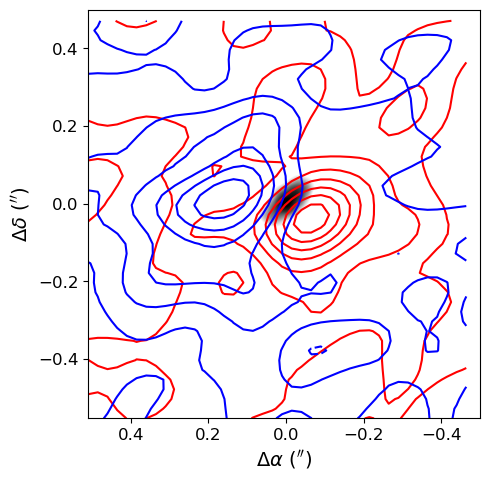

In [9]:
extent=[0.5, -0.5, -0.55, 0.5]

fig = plt.figure(figsize=(5,7))
ax = plt.subplot(111)

cont_Tb_sub = crop_image(cont_Tb, cont_hd, extent)
norm1 = ImageNormalize(cont_Tb_sub, vmin=5, vmax=50, stretch=AsinhStretch(0.3))
p = ax.imshow(cont_Tb_sub, extent=extent, origin='lower', norm=norm1, cmap='binary')

#x, y, CO_red = integrate_v(im1, hd1, -14, -7, extent)
#cr1 = ax.contour(x, y, CO_red, colors='red')
#x, y, CO_blu = integrate_v(im1, hd1, 15, 18, extent)
#cr1 = ax.contour(x, y, CO_blu, colors='blue')

x, y, SO_red = integrate_v(im2, hd2, v_red1, v_red2, extent)
cr1 = ax.contour(x, y, SO_red, colors='red')
x, y, SO_blu = integrate_v(im2, hd2, v_blu1, v_blu2, extent)
cr1 = ax.contour(x, y, SO_blu, colors='blue')


# labels
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.set_xlabel(r"$\Delta\alpha\ ('')$", fontsize=14)
ax.set_ylabel(r"$\Delta\delta\ ('')$", fontsize=14)


fig.tight_layout()
try:
    plt.savefig(pdf)
    print("Image saved as "+pdf)
except:
    pass